In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_distances
from numpy import dot
from numpy.linalg import norm
import torch
import transformers as ppb
import warnings
import random
import matplotlib.pyplot as plt
from os import walk
from itertools import permutations, combinations
import pickle
import time
import statsmodels.api as sm
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score

warnings.filterwarnings('ignore')
%matplotlib inline

In [190]:
def data2df(PATH):
    lines = open(PATH, encoding='iso-8859-1').read().strip().split('\n')
    lines = [line.split("\t") for line in lines]
    lines = pd.DataFrame(lines)
    lines = lines[lines[1] != 'UNCONFIDENT_INTENT_FROM_SLAD']
    lines[1] = lines[1].apply(lambda x: int(x)-1)
    return lines

def df2embd(df):
    max_row = min(len(df[df[1]==1]),len(df[df[1]==0]),1000)
    batch_1 = pd.concat((df[df[1]==1].sample(n=max_row, random_state=1),df[df[1]==0].sample(n=max_row, random_state=1)))
    tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    features = last_hidden_states[0][:,0,:].numpy()
    labels = batch_1[1]
    return features, np.array(labels)

def cos_dist(A, B):
       return 1 - (dot(A, B)/(norm(A)*norm(B)))

def S2T(train_features, train_labels, test_features, test_labels):
    lr_clf = LogisticRegression()
    lr_clf.fit(train_features, train_labels)
    return lr_clf.score(test_features, test_labels)


def S2ti(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))
    
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = np.concatenate((y_train, y_pred), axis=0)
        y_pred_store += y_pred.tolist()
        y_test_store += y_test
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

def S2t1(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))
    
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = [test_features[i] for i,x in targets[0]]
    y_test = [test_labels[i] for i,x in targets[0]]
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(X_test)
    X_train = np.concatenate((X_train, X_test), axis=0)
    y_train = np.concatenate((y_train, y_pred), axis=0)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    output_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    St1_score = sum(output_score)/len(output_score)    
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, St1_score, distribution
    else:
        return original_score, St1_score
    
def self_train(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 

    
    # calculate influence of distribution 
    distribution = cos_dist(source_center, target_center)
    
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(X_test)
    X_train = np.concatenate((X_train, X_test), axis=0)
    y_train = np.concatenate((y_train, y_pred), axis=0)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    output_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    St1_score = sum(output_score)/len(output_score)    
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, St1_score, distribution
    else:
        return original_score, St1_score

def si2ti(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))

    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = X_train[len(X_test):]
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = y_train[len(y_pred):]
        y_train = np.concatenate((y_train, y_pred), axis=0)
        y_pred_store += y_pred.tolist()
        y_test_store += y_test
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

    
    
def si2ti_1by1(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    while len(target_distances)>0:
        X_test = [test_features[target_distances[0][0]]]
        y_test = [test_labels[target_distances[0][0]]]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = X_train[len(X_test):]
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = y_train[len(y_pred):]
        y_train = np.concatenate((y_train, y_pred), axis=0)
        y_pred_store += y_pred.tolist()
        y_test_store += y_test
        target_distances = target_distances[1:]
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

def all_combination_test(func,num_i, include_S2T = True, dist_eval = False):
    data_permu = list(permutations(all_data,2))
    S2T_scores = []
    func_scores = []
    dist_list = []
    for index,permu in enumerate(data_permu):
        try:
            if dist_eval:
                S2T_scr, func_scr, dist = func(permu[0][0], permu[0][1], permu[1][0], permu[1][1],num_i,dist_eval = dist_eval)
                dist_list.append(dist)
            else:
                S2T_scr, func_scr = func(permu[0][0], permu[0][1], permu[1][0], permu[1][1],num_i,dist_eval = dist_eval)
            S2T_scores.append(S2T_scr)
            func_scores.append(func_scr)
            print(index)
        except Exception as e:
            print('error:',permu[0][2],permu[1][2],e)
            S2T_scores.append(999)
            func_scores.append(999)
    
    iterative_scores = [func_scores[i] - S2T_scores[i] for i in range(len(func_scores))]
    
    if dist_eval:
        return iterative_scores,S2T_scores,func_scores, dist_list
    else:
        return iterative_scores,S2T_scores,func_scores
    

def st_tf_distance(domain1, domain2):
    S_T = [domain1[0][i] for i,val in enumerate(domain1[1]) if val == 1]
    S_F = [domain1[0][i] for i,val in enumerate(domain1[1]) if val == 0]
    T_T = [domain2[0][i] for i,val in enumerate(domain2[1]) if val == 1]
    T_F = [domain2[0][i] for i,val in enumerate(domain2[1]) if val == 0]
    S_T_center = np.mean(S_T,axis = 0)
    S_F_center = np.mean(S_F,axis = 0)
    T_T_center = np.mean(T_T,axis = 0)
    T_F_center = np.mean(T_F,axis = 0)
    combi_TF = list(combinations([(S_T_center,'S_T'),(S_F_center,'S_F'),(T_T_center,'T_T'),(T_F_center,'T_F')],2))
    combi_TF_dist = [(cos_dist(d1[0], d2[0]),d1[1], d2[1]) for d1,d2 in combi_TF]
    combi_TF_dist.append((cos_dist(np.mean(domain1[0],axis = 0), np.mean(domain2[0],axis = 0)),'S','T'))
    return combi_TF_dist


def S2ti_lastModel(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))
    
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = np.concatenate((y_train, y_pred), axis=0)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    
    output_score = [test_labels[i]==y_pred[i] for i in range(len(y_pred))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    

def si2ti_lastModel(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))

    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = X_train[len(X_test):]
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = y_train[len(y_pred):]
        y_train = np.concatenate((y_train, y_pred), axis=0)
    
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    
    output_score = [test_labels[i]==y_pred[i] for i in range(len(y_pred))]
    
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    
    
def S2ti_true(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 1],axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))
    
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = np.concatenate((y_train, y_pred), axis=0)
        y_pred_store += y_pred.tolist()
        y_test_store += y_test
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score


def S2ti_false(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 0],axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))
    
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = np.concatenate((y_train, y_pred), axis=0)
        y_pred_store += y_pred.tolist()
        y_test_store += y_test
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

def si2ti_lastModel_true(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 1],axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))

    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = X_train[len(X_test):]
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = y_train[len(y_pred):]
        y_train = np.concatenate((y_train, y_pred), axis=0)
    
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    
    output_score = [test_labels[i]==y_pred[i] for i in range(len(y_pred))]
    
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    
def si2ti_prob(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    conf = 0.1
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(target_distances)>0:
        threshold = min(int(len(test_labels)/num_i),len(target_distances))
        target = target_distances[:threshold]
        target_distances = target_distances[threshold:]
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        X_test_keep = [X_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        y_pred_keep = [y_pred[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        if len(y_pred_keep) != 0:         
            X_train = X_train[len(X_test_keep):]
            X_train = np.concatenate((X_train, X_test_keep), axis=0)
            y_train = y_train[len(y_pred_keep):]
            y_train = np.concatenate((y_train, y_pred_keep), axis=0)
            y_pred_store += y_pred_keep
            y_test_store += [y_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            return_target = [target[i] for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            if len(return_target) == len(previous_r_target):
                break
            previous_r_target = return_target[:]
            target_distances = return_target + target_distances
        else:
            X_train = X_train[len(X_test):]
            X_train = np.concatenate((X_train, X_test), axis=0)
            y_train = y_train[len(y_pred):]
            y_train = np.concatenate((y_train, y_pred), axis=0)
            y_pred_store += y_pred.tolist()
            y_test_store += y_test
        
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

def si2ti_prob_2(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    conf = 0.2
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(target_distances)>0:
        threshold = min(int(len(test_labels)/num_i),len(target_distances))
        target = target_distances[:threshold]
        target_distances = target_distances[threshold:]
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        X_test_keep = [X_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        y_pred_keep = [y_pred[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        if len(y_pred_keep) != 0:         
            X_train = X_train[len(X_test_keep):]
            X_train = np.concatenate((X_train, X_test_keep), axis=0)
            y_train = y_train[len(y_pred_keep):]
            y_train = np.concatenate((y_train, y_pred_keep), axis=0)
            y_pred_store += y_pred_keep
            y_test_store += [y_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            return_target = [target[i] for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            if len(return_target) == len(previous_r_target):
                break
            previous_r_target = return_target[:]
            target_distances = return_target + target_distances
        else:
            X_train = X_train[len(X_test):]
            X_train = np.concatenate((X_train, X_test), axis=0)
            y_train = y_train[len(y_pred):]
            y_train = np.concatenate((y_train, y_pred), axis=0)
            y_pred_store += y_pred.tolist()
            y_test_store += y_test
        
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

def si2ti_prob_3(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    conf = 0.3
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(target_distances)>0:
        threshold = min(int(len(test_labels)/num_i),len(target_distances))
        target = target_distances[:threshold]
        target_distances = target_distances[threshold:]
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        X_test_keep = [X_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        y_pred_keep = [y_pred[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        if len(y_pred_keep) != 0:         
            X_train = X_train[len(X_test_keep):]
            X_train = np.concatenate((X_train, X_test_keep), axis=0)
            y_train = y_train[len(y_pred_keep):]
            y_train = np.concatenate((y_train, y_pred_keep), axis=0)
            y_pred_store += y_pred_keep
            y_test_store += [y_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            return_target = [target[i] for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            if len(return_target) == len(previous_r_target):
                break
            previous_r_target = return_target[:]
            target_distances = return_target + target_distances
        else:
            X_train = X_train[len(X_test):]
            X_train = np.concatenate((X_train, X_test), axis=0)
            y_train = y_train[len(y_pred):]
            y_train = np.concatenate((y_train, y_pred), axis=0)
            y_pred_store += y_pred.tolist()
            y_test_store += y_test
        
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

    
def si2ti_prob_4(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    conf = 0.4
    
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(target_distances)>0:
        threshold = min(int(len(test_labels)/num_i),len(target_distances))
        target = target_distances[:threshold]
        target_distances = target_distances[threshold:]
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        X_test_keep = [X_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        y_pred_keep = [y_pred[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
        if len(y_pred_keep) != 0:         
            X_train = X_train[len(X_test_keep):]
            X_train = np.concatenate((X_train, X_test_keep), axis=0)
            y_train = y_train[len(y_pred_keep):]
            y_train = np.concatenate((y_train, y_pred_keep), axis=0)
            y_pred_store += y_pred_keep
            y_test_store += [y_test[i] for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            return_target = [target[i] for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            if len(return_target) == len(previous_r_target):
                break
            previous_r_target = return_target[:]
            target_distances = return_target + target_distances
        else:
            X_train = X_train[len(X_test):]
            X_train = np.concatenate((X_train, X_test), axis=0)
            y_train = y_train[len(y_pred):]
            y_train = np.concatenate((y_train, y_pred), axis=0)
            y_pred_store += y_pred.tolist()
            y_test_store += y_test
        
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    
    

    
    
def upperbound(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    X_test = test_features
    y_test = test_labels
    lr_clf = LogisticRegression()
    lr_clf.fit(X_test, y_test)
    y_pred = lr_clf.predict(X_test)
    
    output_score = [y_pred[i]==y_test[i] for i in range(len(y_pred))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score


def si2ti_prob_4_adj(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
  
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(target_distances)>0:
        threshold = min(int(len(test_labels)/num_i),len(target_distances))
        target = target_distances[:threshold]
        target_distances = target_distances[threshold:]
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = X_train[len(X_test_keep):]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = y_train[len(y_pred_keep):]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        return_target = [target[i] for i in not_keep_index]
        if len(return_target) == len(previous_r_target):
            break
        previous_r_target = return_target[:]
        target_distances = return_target + target_distances
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    
def si2ti_prob_4_adj_lm(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    source_distances = [cos_dist(target_center, x) for x in train_features]
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(target_distances)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(target_distances)]]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(target_distances)>0:
        threshold = min(int(len(test_labels)/num_i),len(target_distances))
        target = target_distances[:threshold]
        target_distances = target_distances[threshold:]
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = X_train[len(X_test_keep):]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = y_train[len(y_pred_keep):]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        return_target = [target[i] for i in not_keep_index]
        if len(return_target) == len(previous_r_target):
            break
        previous_r_target = return_target[:]
        target_distances = return_target + target_distances
    
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    output_score = [y_pred[i]==test_labels[i] for i in range(len(y_pred))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    
    
def si2T_prob_4_adj(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    source_distances = [cos_dist(target_center, x) for x in train_features]
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1], reverse=True)
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(test_labels)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(test_labels)]]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = X_train[len(X_test_keep):]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = y_train[len(y_pred_keep):]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def si2T_prob_4_adj_rand(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = X_train[len(X_test_keep):]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = y_train[len(y_pred_keep):]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score
    
    
def S2T_prob_4_adj(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
    
def si2T_prob_4_adj_rev(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_center = np.mean(test_features,axis = 0)
    source_distances = [cos_dist(target_center, x) for x in train_features]
    source_distances = [(i,x) for i,x in enumerate(source_distances)]
    source_distances = sorted(source_distances, key=lambda x: x[1])
    
    # gradual training
    X_train = [train_features[i] for i,x in source_distances[:len(test_labels)]]
    y_train = [train_labels[i] for i,x in source_distances[:len(test_labels)]]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = X_train[len(X_test_keep):]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = y_train[len(y_pred_keep):]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score

def S2T_prob_4_adj_cycle_dl(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo = X_pseudo + X_test_keep
        y_pseudo = y_pseudo + y_pred_keep
        lr_clf = LogisticRegression()
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = abs(y_train_prob - 0.5)
        y_train_prob = [(i,prob) for i,prob in enumerate(y_train_prob)]
        y_train_prob = sorted(y_train_prob, key=lambda x: x[1])
        train_not_keep_index = [i for i,val in y_train_prob[:len(keep_index)]]
        len_init_X = len(X_train)
        X_train = [X_train[i] for i in range(len_init_X) if i not in train_not_keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = [y_train[i] for i in range(len_init_X) if i not in train_not_keep_index]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_prob_4_adj_cycle_dm(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo = X_pseudo + X_test_keep
        y_pseudo = y_pseudo + y_pred_keep
        lr_clf = LogisticRegression()
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = abs(y_train_prob - 0.5)
        y_train_prob = [(i,prob) for i,prob in enumerate(y_train_prob)]
        y_train_prob = sorted(y_train_prob, key=lambda x: x[1],reverse = True)
        train_not_keep_index = [i for i,val in y_train_prob[:len(keep_index)]]
        len_init_X = len(X_train)
        X_train = [X_train[i] for i in range(len_init_X) if i not in train_not_keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = [y_train[i] for i in range(len_init_X) if i not in train_not_keep_index]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score

def S2T_prob_4_adj_cycle_dms(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    previous_r_target = []
    X_train_source = train_features[:]
    y_train_source = train_labels[:]
    X_train_target = []
    y_train_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        conf = 0.4
        while len(keep_index) == 0 and conf >=0:
            keep_index = [i for i,val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i,val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i,val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo = X_pseudo + X_test_keep
        y_pseudo = y_pseudo + y_pred_keep
        lr_clf = LogisticRegression()
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train_source)[:, 0]
        y_train_prob = abs(y_train_prob - 0.5)
        y_train_prob = [(i,prob) for i,prob in enumerate(y_train_prob)]
        y_train_prob = sorted(y_train_prob, key=lambda x: x[1],reverse = True)
        train_not_keep_index = [i for i,val in y_train_prob[:len(keep_index)]]
        len_init_X = len(X_train_source)
        X_train_source = [X_train_source[i] for i in range(len_init_X) if i not in train_not_keep_index]
        X_train_target = X_train_target + X_test_keep
        X_train = X_train_source + X_train_target
        y_train_source = [y_train_source[i] for i in range(len_init_X) if i not in train_not_keep_index]
        y_train_target = y_train_target + y_pred_keep
        y_train = y_train_source + y_train_target
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    

def S2T_p4_adj_blc(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 30
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = [val[0] for val in y_prob_P[:top_n]]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = [val[0] for val in y_prob_N[:top_n]]
        keep_index = y_prob_P + y_prob_N
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_p4_adj_Xblc(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 100
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [abs(val-0.5) for val in y_prob]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob = sorted(y_prob, key=lambda x: x[1],reverse = True)
        keep_index = [val[0] for val in y_prob[:top_n]]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_p4_adj_blcTm(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 100
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    X_pseudo = []
    y_pseudo = []
    X_balance = train_features[:]
    y_balance = train_labels[:]
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_balance, y_balance)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [abs(val-0.5) for val in y_prob]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob = sorted(y_prob, key=lambda x: x[1],reverse = True)
        keep_index = [val[0] for val in y_prob[:top_n]]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo += X_test_keep
        y_pseudo += y_pred_keep
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
#         print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
        
        lr_clf = LogisticRegression()
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = [(i,val) for i,val in enumerate(y_train_prob)]
        y_train_prob_P = [val for val in y_train_prob if val[1]<0.5]
        y_train_prob_P = sorted(y_train_prob_P, key=lambda x: x[1])
        y_train_prob_N = [val for val in y_train_prob if val[1]>=0.5]
        y_train_prob_N = sorted(y_train_prob_N, key=lambda x: x[1],reverse = True)
#         y_train_prob = sorted(y_train_prob, key=lambda x: x[1])
        n_pos = sum(y_train)
        n_neg = len(y_train) - sum(y_train)
        if n_pos < n_neg: # if positive dominates
            X_balance = np.concatenate((X_train, [X_train[val[0]] for val in y_train_prob_P[:(n_neg-n_pos)]]), axis=0)
            y_balance = np.concatenate((y_train, [y_train[val[0]] for val in y_train_prob_P[:(n_neg-n_pos)]]), axis=0)
        elif n_pos > n_neg:
            X_balance = np.concatenate((X_train,[X_train[val[0]] for val in y_train_prob_N[:(n_pos-n_neg)]]), axis=0)
            y_balance = np.concatenate((y_train,[y_train[val[0]] for val in y_train_prob_N[:(n_pos-n_neg)]]), axis=0)
        
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
def S2T_p4_adj_blcTl(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 20
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    X_pseudo = []
    y_pseudo = []
    X_balance = train_features[:]
    y_balance = train_labels[:]
    while len(X_test)>0:
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_balance, y_balance)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [abs(val-0.5) for val in y_prob]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob = sorted(y_prob, key=lambda x: x[1],reverse = True)
        keep_index = [val[0] for val in y_prob[:top_n]]
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo += X_test_keep
        y_pseudo += y_pred_keep
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
#         print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
        
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = [(i,val) for i,val in enumerate(y_train_prob)]
        y_train_prob_P = [val for val in y_train_prob if val[1]<0.5]
        y_train_prob_P = sorted(y_train_prob_P, key=lambda x: x[1],reverse = True)
        y_train_prob_N = [val for val in y_train_prob if val[1]>=0.5]
        y_train_prob_N = sorted(y_train_prob_N, key=lambda x: x[1])
#         y_train_prob = sorted(y_train_prob, key=lambda x: x[1])
        n_pos = sum(y_train)
        n_neg = len(y_train) - sum(y_train)
        if n_pos < n_neg: # if positive dominates
            X_balance = np.concatenate((X_train, [X_train[val[0]] for val in y_train_prob_P[:(n_neg-n_pos)]]), axis=0)
            y_balance = np.concatenate((y_train, [y_train[val[0]] for val in y_train_prob_P[:(n_neg-n_pos)]]), axis=0)
        elif n_pos > n_neg:
            X_balance = np.concatenate((X_train,[X_train[val[0]] for val in y_train_prob_N[:(n_pos-n_neg)]]), axis=0)
            y_balance = np.concatenate((y_train,[y_train[val[0]] for val in y_train_prob_N[:(n_pos-n_neg)]]), axis=0)
        
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
    
def S2T_p4_adj_blc_dm_pm(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 1
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    previous_r_target = []
    target_pred_prob_store = []
    
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        
        target_pred = lr_clf.predict(test_features)
        target_prob = lr_clf.predict_proba(test_features)[:, 0]
        target_prob = abs(target_prob-0.5)
        target_pred_prob_store.append([(target_pred[i],target_prob[i]) for i in range(len(test_labels))])
        
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = [val[0] for val in y_prob_P[:top_n]]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = [val[0] for val in y_prob_N[:top_n]]
        keep_index = y_prob_P + y_prob_N
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        
        X_pseudo += X_test_keep
        y_pseudo += y_pred_keep
        lr_clf = LogisticRegression()
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = [(i,val) for i,val in enumerate(y_train_prob)]
        y_train_prob_P = [val for val in y_train_prob if val[1]<0.5]
        y_train_prob_P = sorted(y_train_prob_P, key=lambda x: x[1])
        train_not_keep_index_P = [val[0] for val in y_train_prob_P[:len(y_prob_P)]]
        y_train_prob_N = [val for val in y_train_prob if val[1]>=0.5]
        y_train_prob_N = sorted(y_train_prob_N, key=lambda x: x[1],reverse = True)
        train_not_keep_index_N = [val[0] for val in y_train_prob_N[:len(y_prob_N)]]
        train_not_keep_index = train_not_keep_index_P + train_not_keep_index_N
        
        X_train = [X_train[i] for i in range(len(X_train)) if i not in train_not_keep_index]        
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = [y_train[i] for i in range(len(X_train)) if i not in train_not_keep_index]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
#         print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    
    max_prob = target_pred_prob_store[0]
    for row in target_pred_prob_store:
        max_prob = [sorted([max_prob[i],row[i]], key=lambda x: x[1], reverse = True)[0] for i in range(len(test_labels))]
    max_pred = [val[0] for val in max_prob]
    output_score = [max_pred[i]==test_labels[i] for i in range(len(test_labels))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
    
def S2T_p4_adj_blc_dm(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 30
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    X_pseudo = []
    y_pseudo = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [val for val in y_prob if val[1]<0.5]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = [val[0] for val in y_prob_P[:top_n]]
        y_prob_N = [val for val in y_prob if val[1]>=0.5]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = [val[0] for val in y_prob_N[:top_n]]
        keep_index = y_prob_P + y_prob_N
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')

        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_pseudo += X_test_keep
        y_pseudo += y_pred_keep
        lr_clf = LogisticRegression(n_jobs = -1)
        lr_clf.fit(X_pseudo, y_pseudo)
        y_train_prob = lr_clf.predict_proba(X_train)[:, 0]
        y_train_prob = [(i,val) for i,val in enumerate(y_train_prob)]
        y_train_prob_P = [val for val in y_train_prob if val[1]<0.5]
        y_train_prob_P = sorted(y_train_prob_P, key=lambda x: x[1])
        train_not_keep_index_P = [val[0] for val in y_train_prob_P[:len(y_prob_P)]]
        y_train_prob_N = [val for val in y_train_prob if val[1]>=0.5]
        y_train_prob_N = sorted(y_train_prob_N, key=lambda x: x[1],reverse = True)
        train_not_keep_index_N = [val[0] for val in y_train_prob_N[:len(y_prob_N)]]
        train_not_keep_index = train_not_keep_index_P + train_not_keep_index_N
        X_train = [X_train[i] for i in range(len(X_train)) if i not in train_not_keep_index]        
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = [y_train[i] for i in range(len(X_train)) if i not in train_not_keep_index]
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
#         print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression(n_jobs = -1)
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score
    
    

    
    


In [9]:
# ## Save pickle
# with open("./data/amazon_review/data.pickle","wb") as fw:
#     pickle.dump(all_data, fw)

## Load pickle
with open("./data/amazon_review/data.pickle","rb") as fr:
    all_data = pickle.load(fr)
all_data = [all_data[i] for i,val in enumerate(all_data) if val[2] in 
            ['Movies_and_TV.train','Home_and_Kitchen.train','Electronics.train','Books.train']]
[val[2] for val in all_data]

['Home_and_Kitchen.train',
 'Movies_and_TV.train',
 'Electronics.train',
 'Books.train']

In [10]:
%%notify
upperbounds = all_combination_test(upperbound,5, dist_eval = False)

0
1
2
3
4
5
6
7
8
9
10
11


<IPython.core.display.Javascript object>

In [18]:
%%notify
si2ti_prob_1_5 = all_combination_test(si2ti_prob,5, dist_eval = False)

0
1
2
3
4
5
6
7
8
9
10
11


<IPython.core.display.Javascript object>

In [16]:
%%notify
si2ti_prob_2_5 = all_combination_test(si2ti_prob_2,5, dist_eval = False)

0
1
2
3
4
5
6
7
8
9
10
11


<IPython.core.display.Javascript object>

In [14]:
%%notify
si2ti_prob_3_5 = all_combination_test(si2ti_prob_3,5, dist_eval = False)

0
1
2
3
4
5
6
7
8
9
10
11


<IPython.core.display.Javascript object>

In [12]:
%%notify
si2ti_prob_4_5 = all_combination_test(si2ti_prob_4,5, dist_eval = False)

0
1
2
3
4
5
6
7
8
9
10
11


<IPython.core.display.Javascript object>

In [21]:
%%notify
S2T_prob_4_adj_5 = all_combination_test(S2T_prob_4_adj,5, dist_eval = False)

0
1
2
3
4
5
6
7
8
9
10
11


<IPython.core.display.Javascript object>

In [23]:
%%notify
S2T_prob_4_adj_cycle_dms_5 = all_combination_test(S2T_prob_4_adj_cycle_dms,5, dist_eval = False)

0
1
2
3
4
5
6
7
8
9
10
11


<IPython.core.display.Javascript object>

In [37]:
%%notify
test = all_combination_test(S2T_prob_4_adj_cycle_dms,5, dist_eval = False)

total: 1480 pred_true 584 true_true 662
total: 131 pred_true 42 true_true 67
total: 37 pred_true 10 true_true 19
total: 34 pred_true 13 true_true 17
total: 43 pred_true 22 true_true 31
total: 38 pred_true 18 true_true 25
total: 33 pred_true 13 true_true 21
total: 39 pred_true 20 true_true 24
total: 30 pred_true 15 true_true 22
total: 32 pred_true 15 true_true 28
total: 31 pred_true 12 true_true 26
total: 30 pred_true 15 true_true 21
total: 32 pred_true 17 true_true 28
total: 10 pred_true 5 true_true 9
0.8765 0.8765
0
total: 1456 pred_true 628 true_true 662
total: 109 pred_true 53 true_true 63
total: 43 pred_true 19 true_true 23
total: 30 pred_true 16 true_true 18
total: 35 pred_true 13 true_true 23
total: 37 pred_true 18 true_true 21
total: 33 pred_true 16 true_true 24
total: 31 pred_true 16 true_true 21
total: 38 pred_true 23 true_true 26
total: 30 pred_true 19 true_true 15
total: 31 pred_true 20 true_true 22
total: 32 pred_true 19 true_true 21
total: 33 pred_true 10 true_true 19
tota

<IPython.core.display.Javascript object>

In [48]:
%%notify
S2T_prob_4_adj_cycle_dm_30 = all_combination_test(S2T_prob_4_adj_cycle_dm,5, dist_eval = False)

total: 1480 pred_true 584 true_true 662
total: 131 pred_true 42 true_true 67
total: 35 pred_true 6 true_true 17
total: 40 pred_true 12 true_true 23
total: 33 pred_true 14 true_true 21
total: 31 pred_true 16 true_true 21
total: 35 pred_true 23 true_true 25
total: 39 pred_true 21 true_true 27
total: 32 pred_true 17 true_true 19
total: 37 pred_true 13 true_true 28
total: 30 pred_true 14 true_true 27
total: 30 pred_true 16 true_true 24
total: 30 pred_true 12 true_true 25
total: 16 pred_true 7 true_true 13
total: 1 pred_true 1 true_true 1
0.873 0.873
0
total: 1456 pred_true 628 true_true 662
total: 109 pred_true 53 true_true 63
total: 39 pred_true 21 true_true 21
total: 39 pred_true 17 true_true 24
total: 33 pred_true 14 true_true 18
total: 42 pred_true 18 true_true 27
total: 31 pred_true 12 true_true 18
total: 32 pred_true 16 true_true 19
total: 41 pred_true 19 true_true 26
total: 30 pred_true 16 true_true 23
total: 37 pred_true 20 true_true 23
total: 37 pred_true 18 true_true 26
total: 31

<IPython.core.display.Javascript object>

In [91]:
%%notify
S2T_p4_adj_blc_1 = all_combination_test(S2T_p4_adj_blc,5, dist_eval = False)

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 p

total: 1 pred_true 0 true_true 1
total: 1 pred_true 0 true_true 1
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 1
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 1
total: 1 pred_true 0 true_true 1
total: 1 pred_true 0 true_true 1
total: 1 pred_true 0 true_true 1
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 1
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 1
0.8955 0.8955
0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_t

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 1 pred_true 0 true_true 1
total: 1 pred_true 0 true_true 1
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 0
total: 2 pred_true 1 true_true 1
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 0
0.9035 0.9035
1
total: 2 pred_true 1 true_t

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 1 pred_true 0 true_true 1
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 0
total: 1 pred_true 0 true_true 1
total: 1 pred_true 0 true_true 1
total: 1 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 2
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 p

total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 0
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 2
total: 2 pred_true 1 true_true 1
total: 2 pred_true 1 true_true 1
total: 2 p

<IPython.core.display.Javascript object>

In [73]:
%%notify
S2T_p4_adj_blc_10 = all_combination_test(S2T_p4_adj_blc,5, dist_eval = False)

total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_t

total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 

total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 8
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 8
total: 20 pred_true 10 true_true 13


total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 8
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 8
0.915 0.915
6
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 1

total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_tru

total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 7
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 9
total: 20 pred_true 10 true_true 8
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 10
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 8
total: 20 pred_true 10 true_true 12
total: 20 pred_true 10 true_true 14
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 11
total: 20 pred_true 10 true_true 1

<IPython.core.display.Javascript object>

In [70]:
%%notify
S2T_p4_adj_blc_20 = all_combination_test(S2T_p4_adj_blc,5, dist_eval = False)

total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 22
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 19
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 22
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 22
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 23
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_

total: 40 pred_true 20 true_true 17
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 19
total: 40 pred_true 20 true_true 24
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 23
total: 40 pred_true 20 true_true 18
total: 40 pred_true 20 true_true 19
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 19
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 23
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 23
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 17
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 16
total: 40 pred_true 20 true_true 16
total: 40 pred_true 20 true_true 22
total: 40 pred_true 17 true_true 15
total: 40 pred_true 6 true_true 16
0.8815 0.8815
4
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pre

total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 22
total: 40 pred_true 20 true_true 22
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 19
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_

<IPython.core.display.Javascript object>

In [87]:
%%notify
S2T_p4_adj_blc_30 = all_combination_test(S2T_p4_adj_blc,5, dist_eval = False)

total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 29
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 33
total: 60 pred_true 30 true_true 33
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 28
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 33
total: 60 pred_true 30 true_true 25
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 34
total: 60 pred_true 30 true_true 28
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_

total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 33
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 33
total: 60 pred_true 30 true_true 27
total: 60 pred_true 30 true_true 23
total: 60 pred_true 30 true_true 26
total: 60 pred_true 30 true_true 23
total: 60 pred_true 30 true_true 35
total: 60 pred_true 30 true_true 30
total: 20 pred_true 10 true_true 10
0.917 0.917
6
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 29
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 33
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 29
total: 60 pred

<IPython.core.display.Javascript object>

In [98]:
%%notify
S2T_p4_adj_blc_100 = all_combination_test(S2T_p4_adj_blc,5, dist_eval = False)

total: 200 pred_true 100 true_true 101
total: 200 pred_true 100 true_true 101
total: 200 pred_true 100 true_true 103
total: 200 pred_true 100 true_true 105
total: 200 pred_true 100 true_true 105
total: 200 pred_true 100 true_true 103
total: 200 pred_true 100 true_true 102
total: 200 pred_true 100 true_true 99
total: 200 pred_true 100 true_true 92
total: 164 pred_true 64 true_true 72
total: 36 pred_true 9 true_true 17
0.8955 0.8955
0
total: 200 pred_true 100 true_true 102
total: 200 pred_true 100 true_true 103
total: 200 pred_true 100 true_true 100
total: 200 pred_true 100 true_true 102
total: 200 pred_true 100 true_true 104
total: 200 pred_true 100 true_true 104
total: 200 pred_true 100 true_true 102
total: 200 pred_true 100 true_true 93
total: 200 pred_true 100 true_true 94
total: 183 pred_true 83 true_true 89
total: 17 pred_true 6 true_true 7
0.9025 0.9025
1
total: 200 pred_true 100 true_true 101
total: 200 pred_true 100 true_true 100
total: 200 pred_true 100 true_true 101
total: 200

<IPython.core.display.Javascript object>

In [104]:
%%notify
S2T_p4_adj_Xblc_100 = all_combination_test(S2T_p4_adj_Xblc,5, dist_eval = False)

total: 100 pred_true 62 true_true 62
total: 100 pred_true 51 true_true 52
total: 100 pred_true 50 true_true 51
total: 100 pred_true 41 true_true 41
total: 100 pred_true 28 true_true 30
total: 100 pred_true 20 true_true 23
total: 100 pred_true 19 true_true 24
total: 100 pred_true 11 true_true 18
total: 100 pred_true 16 true_true 24
total: 100 pred_true 19 true_true 34
total: 100 pred_true 24 true_true 39
total: 100 pred_true 27 true_true 43
total: 100 pred_true 23 true_true 48
total: 100 pred_true 25 true_true 45
total: 100 pred_true 40 true_true 62
total: 100 pred_true 37 true_true 67
total: 100 pred_true 45 true_true 84
total: 100 pred_true 46 true_true 73
total: 100 pred_true 47 true_true 90
total: 100 pred_true 60 true_true 90
0.829 0.8285
0
total: 100 pred_true 54 true_true 55
total: 100 pred_true 41 true_true 42
total: 100 pred_true 41 true_true 42
total: 100 pred_true 36 true_true 38
total: 100 pred_true 34 true_true 35
total: 100 pred_true 29 true_true 30
total: 100 pred_true 39

total: 100 pred_true 52 true_true 76
total: 100 pred_true 54 true_true 66
0.8945 0.8945
10
total: 100 pred_true 21 true_true 22
total: 100 pred_true 30 true_true 34
total: 100 pred_true 23 true_true 23
total: 100 pred_true 15 true_true 18
total: 100 pred_true 9 true_true 13
total: 100 pred_true 7 true_true 16
total: 100 pred_true 8 true_true 21
total: 100 pred_true 5 true_true 17
total: 100 pred_true 1 true_true 19
total: 100 pred_true 3 true_true 30
total: 100 pred_true 7 true_true 45
total: 100 pred_true 8 true_true 54
total: 100 pred_true 5 true_true 59
total: 100 pred_true 5 true_true 73
total: 100 pred_true 7 true_true 82
total: 100 pred_true 13 true_true 89
total: 100 pred_true 16 true_true 94
total: 100 pred_true 18 true_true 98
total: 100 pred_true 18 true_true 96
total: 100 pred_true 26 true_true 97
0.6145 0.6165
11


<IPython.core.display.Javascript object>

In [108]:
%%notify
S2T_p4_adj_blcT_100 = all_combination_test(S2T_p4_adj_blcT,5, dist_eval = False)

total: 100 pred_true 62 true_true 62
error: Home_and_Kitchen.train Movies_and_TV.train operands could not be broadcast together with shapes (2100,768) (24,768) 
total: 100 pred_true 54 true_true 55
error: Home_and_Kitchen.train Electronics.train operands could not be broadcast together with shapes (2100,768) (8,768) 
total: 100 pred_true 85 true_true 85
error: Home_and_Kitchen.train Books.train operands could not be broadcast together with shapes (2100,768) (70,768) 
total: 100 pred_true 63 true_true 63
error: Movies_and_TV.train Home_and_Kitchen.train operands could not be broadcast together with shapes (2100,768) (26,768) 
total: 100 pred_true 29 true_true 30
error: Movies_and_TV.train Electronics.train operands could not be broadcast together with shapes (2100,768) (42,768) 
total: 100 pred_true 100 true_true 100
error: Movies_and_TV.train Books.train This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
total: 100 pred_true 92 true_tru

<IPython.core.display.Javascript object>

In [183]:
%%notify
S2T_p4_adj_blcTl_20 = all_combination_test(S2T_p4_adj_blcTl,5, dist_eval = False)

0.8795 0.8795
0
0.8955 0.8955
1
error: Home_and_Kitchen.train Books.train This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [179]:
%%notify
S2T_p4_adj_blcTl_100 = all_combination_test(S2T_p4_adj_blcTl,5, dist_eval = False)

0.8755 0.8755
0
0.894 0.894
1
0.9045 0.9045
2
0.871 0.871
3
0.857 0.857
4
error: Movies_and_TV.train Books.train This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
0.9125 0.9125
6
0.907 0.907
7
0.905 0.9045
8
0.87 0.87
9
0.8985 0.8985
10
0.865 0.865
11


<IPython.core.display.Javascript object>

In [181]:
%%notify
S2T_p4_adj_blcTm_100 = all_combination_test(S2T_p4_adj_blcTm,5, dist_eval = False)

0.844 0.844
0
0.8885 0.8885
1
0.901 0.901
2
0.827 0.8265
3
0.797 0.7965
4
error: Movies_and_TV.train Books.train This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
0.9135 0.9135
6
0.904 0.904
7
0.904 0.9035
8
0.814 0.814
9
0.895 0.895
10
0.797 0.797
11


<IPython.core.display.Javascript object>

In [248]:
%%notify
S2T_p4_adj_blc_dm_pm_30 = all_combination_test(S2T_p4_adj_blc_dm_pm,5, dist_eval = False)

0.9055 0.902
0
0.904 0.901
1
0.9125 0.9085
2
0.8875 0.891
3
0.8785 0.8885
4
0.922 0.9205
5
0.921 0.9215
6
0.9055 0.8975
7
0.9165 0.9045
8
0.882 0.878
9
0.902 0.9035
10
0.88 0.881
11


<IPython.core.display.Javascript object>

In [250]:
%%notify
S2T_p4_adj_blc_dm_pm_1 = all_combination_test(S2T_p4_adj_blc_dm_pm,5, dist_eval = False)

0.9005 0.901
0
0.9015 0.903
1
0.914 0.913
2
0.8905 0.891
3
0.8805 0.886
4
0.92 0.9185
5
0.916 0.9165
6
0.9035 0.899
7
0.916 0.907
8
0.879 0.8795
9
0.9035 0.904
10
0.8795 0.8845
11


<IPython.core.display.Javascript object>

In [257]:
%%notify
S2T_p4_adj_blcTl = all_combination_test(S2T_p4_adj_blcTl,5, dist_eval = False)

0.8795 0.8795
0
0.8955 0.8955
1
error: Home_and_Kitchen.train Books.train This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
0.88 0.88
3
0.874 0.874
4
error: Movies_and_TV.train Books.train This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
error: Electronics.train Home_and_Kitchen.train This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
error: Electronics.train Movies_and_TV.train This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
error: Electronics.train Books.train This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [300]:
%%notify
S2T_p4_adj_blc_int_30 = all_combination_test(S2T_p4_adj_blc_int,5, dist_eval = False)

total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 29
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 34
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 34
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 28
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 29
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 35
total: 60 pred_true 30 true_true 26
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_

total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 36
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 29
total: 60 pred_true 30 true_true 23
total: 60 pred_true 30 true_true 24
total: 60 pred_true 30 true_true 26
total: 60 pred_true 30 true_true 35
total: 60 pred_true 30 true_true 31
total: 20 pred_true 10 true_true 8
0.916 0.916
6
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 29
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 33
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 30
total: 60 pred_

<IPython.core.display.Javascript object>

In [306]:
%%notify
S2T_adj_blc_int_30 = all_combination_test(S2T_adj_blc_int,5, dist_eval = False)

total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 29
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 33
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 34
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 33
total: 60 pred_true 30 true_true 28
total: 60 pred_true 30 true_true 35
total: 60 pred_true 30 true_true 34
total: 60 pred_true 30 true_true 29
total: 60 pred_true 30 true_

total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 28
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 29
total: 60 pred_true 30 true_true 29
total: 60 pred_true 30 true_true 33
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 29
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 33
total: 60 pred_true 30 true_true 32
total: 60 pred_true 30 true_true 31
total: 60 pred_true 30 true_true 35
total: 60 pred_true 30 true_true 27
total: 60 pred_true 30 true_true 27
total: 60 pred_true 30 true_true 28
total: 60 pred_true 30 true_true 21
total: 60 pred_true 30 true_true 30
total: 60 pred_true 30 true_

<IPython.core.display.Javascript object>

In [56]:
S2T_prob_4_adj(all_data[0][0], all_data[0][1],all_data[1][0], all_data[1][1], 5)

total: 1480 pred_true 584 true_true 662
total: 112 pred_true 23 true_true 53
total: 45 pred_true 8 true_true 17
total: 34 pred_true 7 true_true 18
total: 42 pred_true 11 true_true 22
total: 30 pred_true 8 true_true 22
total: 38 pred_true 8 true_true 28
total: 37 pred_true 15 true_true 28
total: 35 pred_true 16 true_true 26
total: 31 pred_true 17 true_true 25
total: 33 pred_true 25 true_true 27
total: 32 pred_true 21 true_true 30
total: 35 pred_true 26 true_true 29
total: 13 pred_true 7 true_true 10
total: 3 pred_true 2 true_true 3
0.862 0.862


(0.862, 0.862)

In [45]:
S2T_prob_4_adj_cycle_dm(all_data[0][0], all_data[0][1],all_data[1][0], all_data[1][1], 5)

total: 1480 pred_true 584 true_true 662
total: 131 pred_true 42 true_true 67
total: 35 pred_true 6 true_true 17
total: 40 pred_true 12 true_true 23
total: 33 pred_true 14 true_true 21
total: 31 pred_true 16 true_true 21
total: 35 pred_true 23 true_true 25
total: 39 pred_true 21 true_true 27
total: 32 pred_true 17 true_true 19
total: 37 pred_true 13 true_true 28
total: 30 pred_true 14 true_true 27
total: 30 pred_true 16 true_true 24
total: 30 pred_true 12 true_true 25
total: 16 pred_true 7 true_true 13
total: 1 pred_true 1 true_true 1


(0.873, 0.873)

In [34]:
S2T_prob_4_adj_cycle_dms(all_data[0][0], all_data[0][1],all_data[1][0], all_data[1][1], 5)

1480 584 662
131 42 67
37 10 19
34 13 17
43 22 31
38 18 25
33 13 21
39 20 24
30 15 22
32 15 28
31 12 26
30 15 21
32 17 28
10 5 9


(0.8765, 0.8765)

In [68]:
S2T_p4_adj_blc(all_data[0][0], all_data[0][1],all_data[1][0], all_data[1][1], 5)

total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 22
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 19
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 22
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 20
total: 40 pred_true 20 true_true 22
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_true 23
total: 40 pred_true 20 true_true 21
total: 40 pred_true 20 true_

(0.898, 0.898)

In [176]:
S2T_p4_adj_blcTl(all_data[0][0], all_data[0][1],all_data[1][0], all_data[1][1], 5)

total: 100 pred_true 62 true_true 62
total: 100 pred_true 52 true_true 53
total: 100 pred_true 51 true_true 51
total: 100 pred_true 35 true_true 37
total: 100 pred_true 30 true_true 31
total: 100 pred_true 27 true_true 30
total: 100 pred_true 34 true_true 39
total: 100 pred_true 21 true_true 28
total: 100 pred_true 19 true_true 24
total: 100 pred_true 19 true_true 29
total: 100 pred_true 19 true_true 34
total: 100 pred_true 30 true_true 48
total: 100 pred_true 41 true_true 55
total: 100 pred_true 42 true_true 59
total: 100 pred_true 45 true_true 55
total: 100 pred_true 57 true_true 71
total: 100 pred_true 60 true_true 71
total: 100 pred_true 57 true_true 68
total: 100 pred_true 67 true_true 85
total: 100 pred_true 59 true_true 70
0.8755 0.8755


(0.8755, 0.8755)

In [164]:
S2T_p4_adj_Xblc(all_data[0][0], all_data[0][1],all_data[1][0], all_data[1][1], 5)

total: 100 pred_true 62 true_true 62
total: 100 pred_true 51 true_true 52
total: 100 pred_true 50 true_true 51
total: 100 pred_true 41 true_true 41
total: 100 pred_true 28 true_true 30
total: 100 pred_true 20 true_true 23
total: 100 pred_true 19 true_true 24
total: 100 pred_true 11 true_true 18
total: 100 pred_true 16 true_true 24
total: 100 pred_true 19 true_true 34
total: 100 pred_true 24 true_true 39
total: 100 pred_true 27 true_true 43
total: 100 pred_true 23 true_true 48
total: 100 pred_true 25 true_true 45
total: 100 pred_true 40 true_true 62
total: 100 pred_true 37 true_true 67
total: 100 pred_true 45 true_true 84
total: 100 pred_true 46 true_true 73
total: 100 pred_true 47 true_true 90
total: 100 pred_true 60 true_true 90
0.829 0.8285


(0.829, 0.8285)

In [246]:
S2T_p4_adj_blc_dm(all_data[0][0], all_data[0][1],all_data[1][0], all_data[1][1], 5)

0.9055 0.9055


(0.9055, 0.9055)

In [244]:
S2T_p4_adj_blc_dm_pm(all_data[0][0], all_data[0][1],all_data[1][0], all_data[1][1], 5)

0.9055 0.902


(0.9055, 0.902)

In [304]:
def S2T_p4_adj_blc_int(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 30
    
    s_center_P = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 1],axis = 0)
    s_center_N = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 0],axis = 0)
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [y_prob[i] for i,val in enumerate(y_pred) if val==1]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = [val[0] for val in y_prob_P[:top_n]]
        y_prob_N = [y_prob[i] for i,val in enumerate(y_pred) if val==0]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = [val[0] for val in y_prob_N[:top_n]]
        keep_index = y_prob_P + y_prob_N
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')
        
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        
        X_test_keep_P = [X_test[i] for i in y_prob_P]
        y_pred_keep_P = [y_pred[i] for i in y_prob_P]
        X_test_keep_N = [X_test[i] for i in y_prob_N]
        y_pred_keep_N = [y_pred[i] for i in y_prob_N]
        
        X_inter_P = [np.mean([s_center_P,val],axis = 0) for val in X_test_keep_P]
        X_inter_N = [np.mean([s_center_N,val],axis = 0) for val in X_test_keep_N]
        
        X_train = np.concatenate([x for x in [X_train, X_test_keep, X_inter_P, X_inter_N] if len(x) >0], axis=0)
        y_train = np.concatenate([x for x in [y_train, y_pred_keep,y_pred_keep_P,y_pred_keep_N] if len(x) >0], axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score

In [305]:
def S2T_adj_blc_int(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    top_n = 30
    
    s_center_P = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 1],axis = 0)
    s_center_N = np.mean([train_features[i] for i,value in enumerate(train_labels) if value == 0],axis = 0)
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test)>0:
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        y_prob = [(i,val,y_pred[i]) for i,val in enumerate(y_prob)]
        y_prob_P = [y_prob[i] for i,val in enumerate(y_pred) if val==1]
        y_prob_P = sorted(y_prob_P, key=lambda x: x[1])
        y_prob_P = [val[0] for val in y_prob_P[:top_n]]
        y_prob_N = [y_prob[i] for i,val in enumerate(y_pred) if val==0]
        y_prob_N = sorted(y_prob_N, key=lambda x: x[1],reverse = True)
        y_prob_N = [val[0] for val in y_prob_N[:top_n]]
        keep_index = y_prob_P + y_prob_N
        not_keep_index = [i for i in range(len(y_pred)) if i not in keep_index]
        if len(keep_index)+len(not_keep_index) != len(y_pred):
            raise ValueError('top_n error!')
        
        X_test_keep = [X_test[i] for i in keep_index]
        y_pred_keep = [y_pred[i] for i in keep_index]
        
        X_test_keep_P = [X_test[i] for i in y_prob_P]
        y_pred_keep_P = [y_pred[i] for i in y_prob_P]
        X_test_keep_N = [X_test[i] for i in y_prob_N]
        y_pred_keep_N = [y_pred[i] for i in y_prob_N]
        
        X_inter_P = [np.mean([s_center_P,val],axis = 0) for val in X_test_keep_P]
        X_inter_N = [np.mean([s_center_N,val],axis = 0) for val in X_test_keep_N]
        
        X_train = np.concatenate([x for x in [X_train, X_inter_P, X_inter_N] if len(x) >0], axis=0)
        y_train = np.concatenate([x for x in [y_train, y_pred_keep_P,y_pred_keep_N] if len(x) >0], axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        print('total:',len(y_pred_keep),'pred_true',sum(y_pred_keep),'true_true',sum([y_test[i] for i in keep_index]))
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_test[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i]==test_labels[i] for i in range(len(test_labels))]
    lm_score = sum(lm_score)/len(lm_score)
    print(lm_score, gradual_score)
    
    if dist_eval:
        return lm_score, gradual_score, distribution
    else:
        return lm_score, gradual_score

In [266]:
[np.mean(val) for val in plot_data[1:]]

[0.8724999999999999,
 0.8819755153451824,
 0.8785416666666667,
 0.8813289117487818,
 0.8830494323796897,
 0.875,
 0.8749166666666666,
 0.8796666666666667,
 0.8796666666666666,
 0.8797499999999999,
 0.8762083333333335,
 0.9009999999999999,
 0.9009999999999999,
 0.9005416666666667,
 0.9005416666666667,
 0.900875,
 0.900875,
 0.9014583333333334,
 0.9014583333333334,
 0.9000416666666666,
 0.8997083333333333,
 0.8252083333333333,
 0.8253750000000001,
 84.06333333333332,
 84.06329166666666,
 84.04041666666667,
 84.04029166666668,
 0.9014166666666665,
 0.9013333333333332,
 0.9014166666666665,
 0.8997916666666667,
 0.9003749999999999,
 0.9002499999999999,
 0.9014583333333334,
 0.9014583333333334]

In [271]:
max([np.mean(val) for val in plot_data[1:]])

0.9014583333333334

In [275]:
np.mean(S2T_p4_adj_blc_dm_pm_30[1])

0.9014166666666665

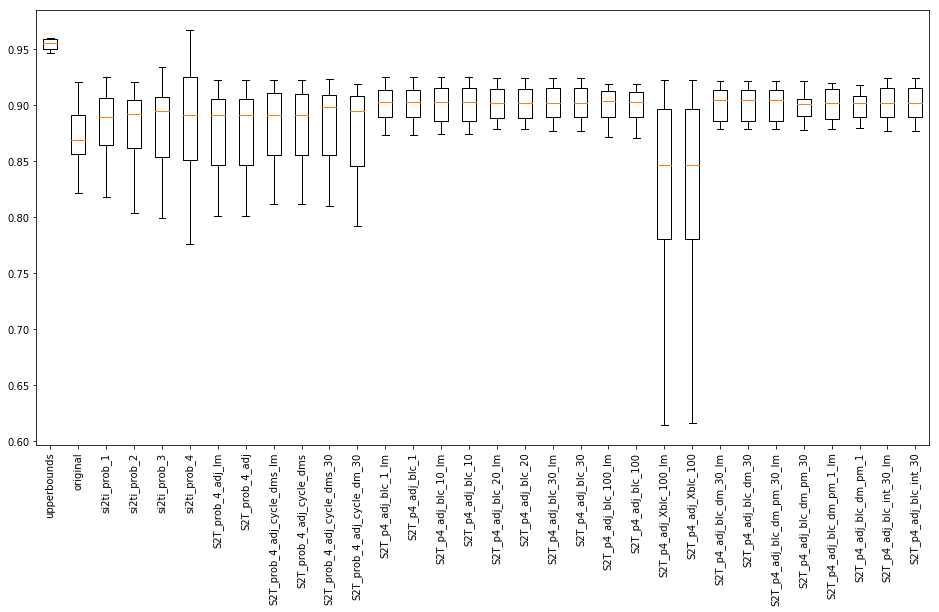

In [282]:
plot_data = [upperbounds[2], si2ti_prob_4_5[1],
             si2ti_prob_1_5[2],si2ti_prob_2_5[2],si2ti_prob_3_5[2],si2ti_prob_4_5[2],
             S2T_prob_4_adj_5[1],S2T_prob_4_adj_5[2],
             S2T_prob_4_adj_cycle_dms_5[1],S2T_prob_4_adj_cycle_dms_5[2],
             test[2],S2T_prob_4_adj_cycle_dm_30[2],
             S2T_p4_adj_blc_1[1],S2T_p4_adj_blc_1[2],
             S2T_p4_adj_blc_10[1],S2T_p4_adj_blc_10[2],
             S2T_p4_adj_blc_20[1],S2T_p4_adj_blc_20[2],
             S2T_p4_adj_blc_30[1],S2T_p4_adj_blc_30[2],
             S2T_p4_adj_blc_100[1],S2T_p4_adj_blc_100[2],
             S2T_p4_adj_Xblc_100[1],S2T_p4_adj_Xblc_100[2],
#              S2T_p4_adj_blcTl_100[1],S2T_p4_adj_blcTl_100[2],
#              S2T_p4_adj_blcTm_100[1],S2T_p4_adj_blcTm_100[2],
             S2T_p4_adj_blc_dm_30[1],S2T_p4_adj_blc_dm_30[2],
             S2T_p4_adj_blc_dm_pm_30[1],S2T_p4_adj_blc_dm_pm_30[2],
             S2T_p4_adj_blc_dm_pm_1[1],S2T_p4_adj_blc_dm_pm_1[2],
             S2T_p4_adj_blc_int_30[1],S2T_p4_adj_blc_int_30[2],
            ]


plt.figure(figsize = [16,8])
plt.boxplot(plot_data,
            labels = ['upperbounds','original',
                      'si2ti_prob_1','si2ti_prob_2','si2ti_prob_3','si2ti_prob_4',
                      'S2T_prob_4_adj_lm','S2T_prob_4_adj',
                      'S2T_prob_4_adj_cycle_dms_lm','S2T_prob_4_adj_cycle_dms',
                      'S2T_prob_4_adj_cycle_dms_30','S2T_prob_4_adj_cycle_dm_30',
                      'S2T_p4_adj_blc_1_lm','S2T_p4_adj_blc_1',
                      'S2T_p4_adj_blc_10_lm','S2T_p4_adj_blc_10',
                      'S2T_p4_adj_blc_20_lm','S2T_p4_adj_blc_20',
                      'S2T_p4_adj_blc_30_lm','S2T_p4_adj_blc_30',
                      'S2T_p4_adj_blc_100_lm','S2T_p4_adj_blc_100',
                      'S2T_p4_adj_Xblc_100_lm','S2T_p4_adj_Xblc_100',
#                       'S2T_p4_adj_blcTl_100_lm','S2T_p4_adj_blcTl_100',
#                       'S2T_p4_adj_blcTm_100_lm','S2T_p4_adj_blcTm_100',
                      'S2T_p4_adj_blc_dm_30_lm','S2T_p4_adj_blc_dm_30',
                      'S2T_p4_adj_blc_dm_pm_30_lm','S2T_p4_adj_blc_dm_pm_30',
                      'S2T_p4_adj_blc_dm_pm_1_lm','S2T_p4_adj_blc_dm_pm_1',
                      'S2T_p4_adj_blc_int_30_lm','S2T_p4_adj_blc_int_30'
                     ], 
            showfliers=False)
# plt.axvline(x=0.903,color = 'r')
plt.xticks(rotation=90)
plt.show()

In [302]:
[np.mean(val) for val in [upperbounds[2], si2ti_prob_4_5[1],
             S2T_p4_adj_blc_1[1],
             S2T_p4_adj_blc_10[1],
             S2T_p4_adj_blc_20[1],
             S2T_p4_adj_blc_30[1],
             S2T_p4_adj_blc_100[1],
             S2T_p4_adj_blc_dm_30[1],
             S2T_p4_adj_blc_dm_1[1],
             S2T_p4_adj_blc_dm_pm_30[1],S2T_p4_adj_blc_dm_pm_30[2],
             S2T_p4_adj_blc_dm_pm_1[1],S2T_p4_adj_blc_dm_pm_1[2],
             S2T_p4_adj_blc_int_30[1],S2T_p4_adj_blc_int_30[2],
            ]]

[0.9544999999999999,
 0.8724999999999999,
 0.9009999999999999,
 0.9005416666666667,
 0.900875,
 0.9014583333333334,
 0.9000416666666666,
 0.9014166666666665,
 0.9003749999999999,
 0.9014166666666665,
 0.8997916666666667,
 0.9003749999999999,
 0.9002499999999999,
 0.9013333333333334,
 0.9013749999999999]

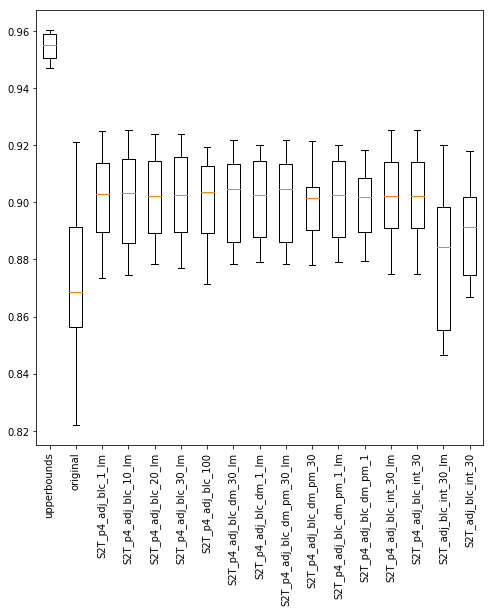

In [307]:
plt.figure(figsize = [8,8])
plt.boxplot([upperbounds[2], si2ti_prob_4_5[1],
             S2T_p4_adj_blc_1[1],
             S2T_p4_adj_blc_10[1],
             S2T_p4_adj_blc_20[1],
             S2T_p4_adj_blc_30[1],
             S2T_p4_adj_blc_100[1],
             S2T_p4_adj_blc_dm_30[1],
             S2T_p4_adj_blc_dm_1[1],
             S2T_p4_adj_blc_dm_pm_30[1],S2T_p4_adj_blc_dm_pm_30[2],
             S2T_p4_adj_blc_dm_pm_1[1],S2T_p4_adj_blc_dm_pm_1[2],
             S2T_p4_adj_blc_int_30[1],S2T_p4_adj_blc_int_30[2],
             S2T_adj_blc_int_30[1],S2T_adj_blc_int_30[2]
            ],
            labels = ['upperbounds','original',
                      'S2T_p4_adj_blc_1_lm',
                      'S2T_p4_adj_blc_10_lm',
                      'S2T_p4_adj_blc_20_lm',
                      'S2T_p4_adj_blc_30_lm',
                      'S2T_p4_adj_blc_100',
                      'S2T_p4_adj_blc_dm_30_lm',
                      'S2T_p4_adj_blc_dm_1_lm',
                      'S2T_p4_adj_blc_dm_pm_30_lm','S2T_p4_adj_blc_dm_pm_30',
                      'S2T_p4_adj_blc_dm_pm_1_lm','S2T_p4_adj_blc_dm_pm_1',
                      'S2T_p4_adj_blc_int_30_lm','S2T_p4_adj_blc_int_30',
                      'S2T_adj_blc_int_30_lm','S2T_adj_blc_int_30'
                     ], 
            showfliers=False)
plt.xticks(rotation=90)
plt.show()

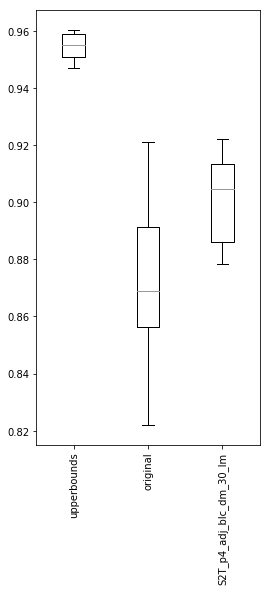

In [211]:
plt.figure(figsize = [4,8])
plt.boxplot([upperbounds[2], si2ti_prob_4_5[1],
             S2T_p4_adj_blc_dm_30[1],
            ],
            labels = ['upperbounds','original',
                      'S2T_p4_adj_blc_dm_30_lm',
                     ], 
            showfliers=False)
plt.xticks(rotation=90)
plt.show()